<a href="https://colab.research.google.com/github/fa7ih/surucuyorgunluk/blob/main/surucuyorgunluk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!#!/bin/bash
!curl -L -o /content/driver-drowsiness-dataset-ddd.zip \
  https://www.kaggle.com/api/v1/datasets/download/ismailnasri20/driver-drowsiness-dataset-ddd
!unzip -o /content/driver-drowsiness-dataset-ddd.zip -d /content
!rm /content/driver-drowsiness-dataset-ddd.zip
!echo "Dataset indirildi ve çıkarıldı."

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: /content/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: /content/Driver 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from timm import create_model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from PIL import Image

data_dir = '/content/dataset'
categories = ['Drowsy', 'NonDrowsy']

class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

all_filepaths = []
all_labels = []
for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        filepath = os.path.join(category_dir, filename)
        all_filepaths.append(filepath)
        all_labels.append(i)  # Integer formatında kategoriler

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_metrics = []

class LeViTModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(LeViTModel, self).__init__()
        self.backbone = create_model('levit_384', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy, all_preds, all_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

for fold, (train_index, val_index) in enumerate(kf.split(all_filepaths)):
    print(f"Fold {fold + 1}")

    train_filepaths = np.array(all_filepaths)[train_index]
    train_labels = np.array(all_labels)[train_index]
    val_filepaths = np.array(all_filepaths)[val_index]
    val_labels = np.array(all_labels)[val_index]

    train_dataset = CustomDataset(train_filepaths, train_labels, transform=transform)
    val_dataset = CustomDataset(val_filepaths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = LeViTModel(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 3
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, val_preds, val_labels = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    save_path = f'levit_model_fold_{fold + 1}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Model fold {fold + 1} olarak {save_path} dosyasına kaydedildi.")



Fold 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/157M [00:00<?, ?B/s]

Epoch 1/3, Train Loss: 0.0477, Val Loss: 0.0020, Val Accuracy: 0.9998
Epoch 2/3, Train Loss: 0.0046, Val Loss: 0.0001, Val Accuracy: 1.0000
Epoch 3/3, Train Loss: 0.0031, Val Loss: 0.0002, Val Accuracy: 1.0000
Model fold 1 olarak levit_model_fold_1.pth dosyasına kaydedildi.
Fold 2
Epoch 1/3, Train Loss: 0.0459, Val Loss: 0.0020, Val Accuracy: 0.9994
Epoch 2/3, Train Loss: 0.0031, Val Loss: 0.0004, Val Accuracy: 0.9999
Epoch 3/3, Train Loss: 0.0024, Val Loss: 0.0001, Val Accuracy: 1.0000
Model fold 2 olarak levit_model_fold_2.pth dosyasına kaydedildi.
Fold 3
Epoch 1/3, Train Loss: 0.0504, Val Loss: 0.0013, Val Accuracy: 0.9998
Epoch 2/3, Train Loss: 0.0037, Val Loss: 0.0003, Val Accuracy: 1.0000
Epoch 3/3, Train Loss: 0.0019, Val Loss: 0.0001, Val Accuracy: 1.0000
Model fold 3 olarak levit_model_fold_3.pth dosyasına kaydedildi.
Fold 4
Epoch 1/3, Train Loss: 0.0461, Val Loss: 0.0007, Val Accuracy: 1.0000
Epoch 2/3, Train Loss: 0.0044, Val Loss: 0.0003, Val Accuracy: 1.0000
Epoch 3/3, Tra

In [ ]:
!pip install playsound


  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=b63c6076b0e5af3253c028db918cadfbe1047716add7857c0e2512e70cd3d5e3
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


In [ ]:
import pandas as pd

data = {
    'Fold': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5,5,5],
    'Epoch': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,2,3],
    'Train Loss': [0.0477,0.0046,0.0031,0.0459,0.0031,0.0024,0.0504,0.0037,0.0019,0.0461,0.0044,0.0025,0.0470,0.0073,0.0023],
    'Val Loss': [0.0020, 0.0001, 0.0002, 0.0020, 0.0004, 0.0001, 0.0013, 0.0003, 0.0001, 0.0007, 0.0003, 0.0013, 0.0057,0.0007,2.8587],
    'Val Accuracy': [0.9998, 1.0000, 1.0000, 0.9994, 0.9999, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9999, 0.9999, 0.9999]
}
df = pd.DataFrame(data)

df.to_csv('/content/makine/dataframe.csv', index=False)

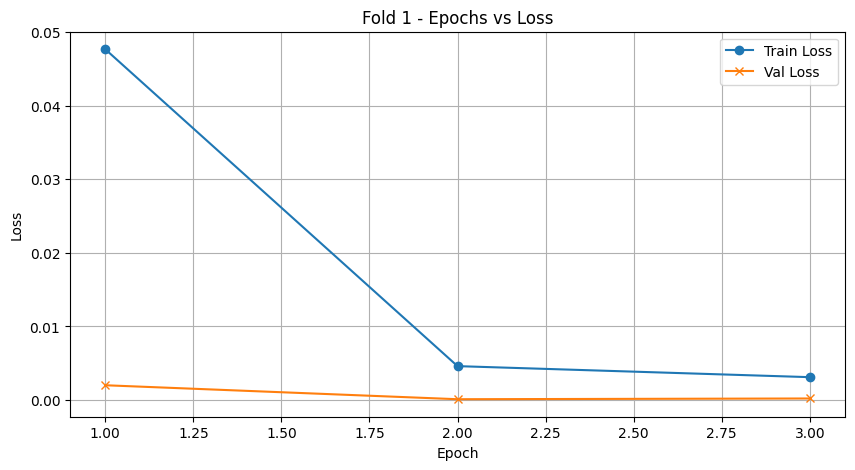

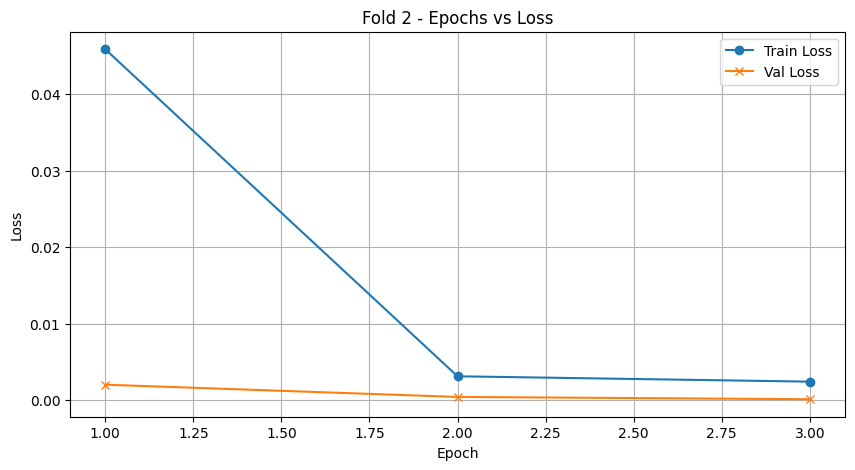

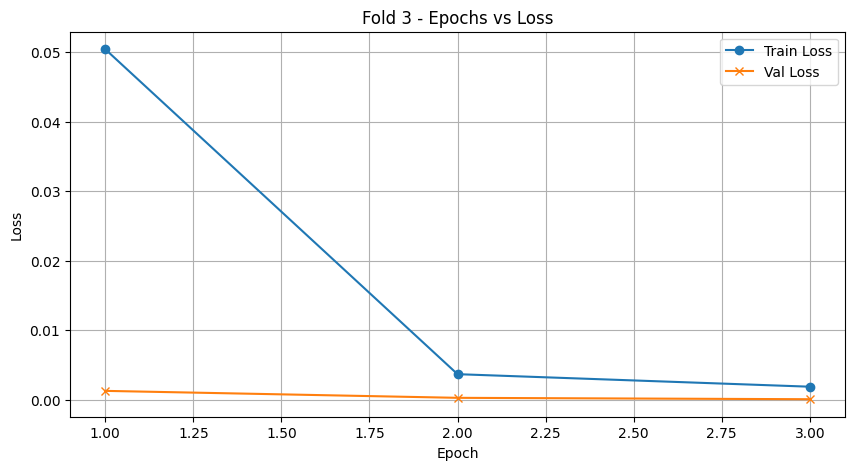

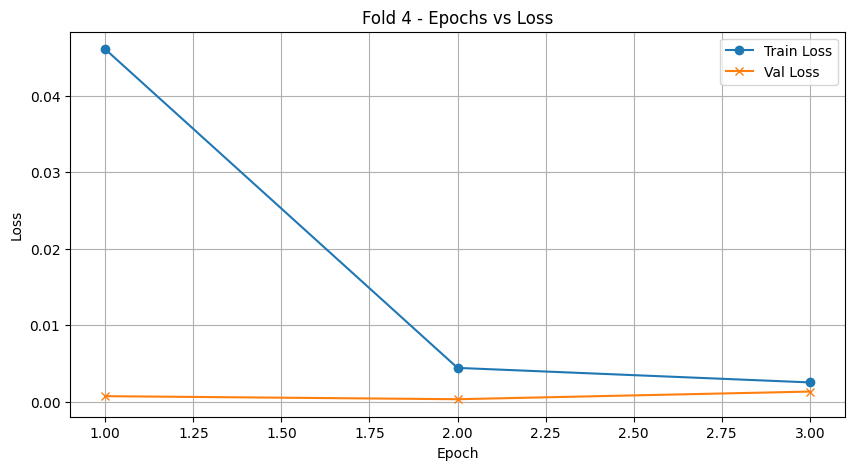

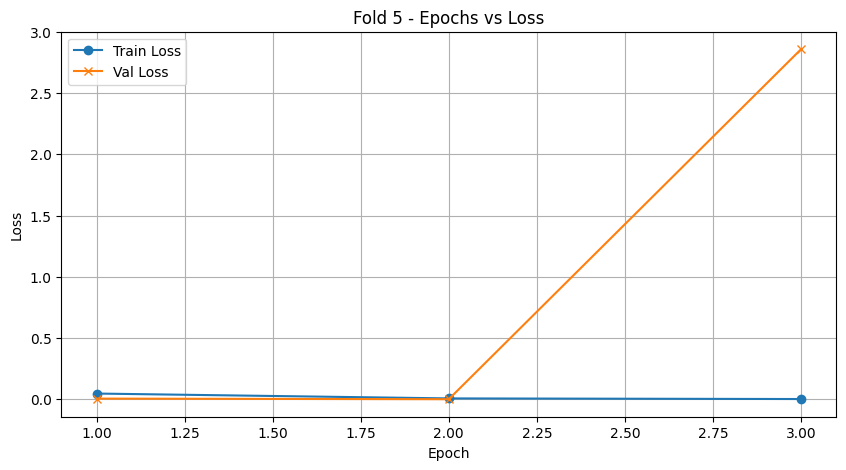

In [ ]:
import matplotlib.pyplot as plt

data = {
    'Fold': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5,5,5],
    'Epoch': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,2,3],
    'Train Loss': [0.0477,0.0046,0.0031,0.0459,0.0031,0.0024,0.0504,0.0037,0.0019,0.0461,0.0044,0.0025,0.0470,0.0073,0.0023],
    'Val Loss': [0.0020, 0.0001, 0.0002, 0.0020, 0.0004, 0.0001, 0.0013, 0.0003, 0.0001, 0.0007, 0.0003, 0.0013, 0.0057,0.0007,2.8587],
    'Val Accuracy': [0.9998, 1.0000, 1.0000, 0.9994, 0.9999, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9999, 0.9999, 0.9999]
}

folds = sorted(set(data['Fold']))
for fold in folds:
    fold_data = {k: [v for i, v in enumerate(data[k]) if data['Fold'][i] == fold] for k in data}
    epochs = fold_data['Epoch']
    train_losses = fold_data['Train Loss']
    val_losses = fold_data['Val Loss']

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold} - Epochs vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

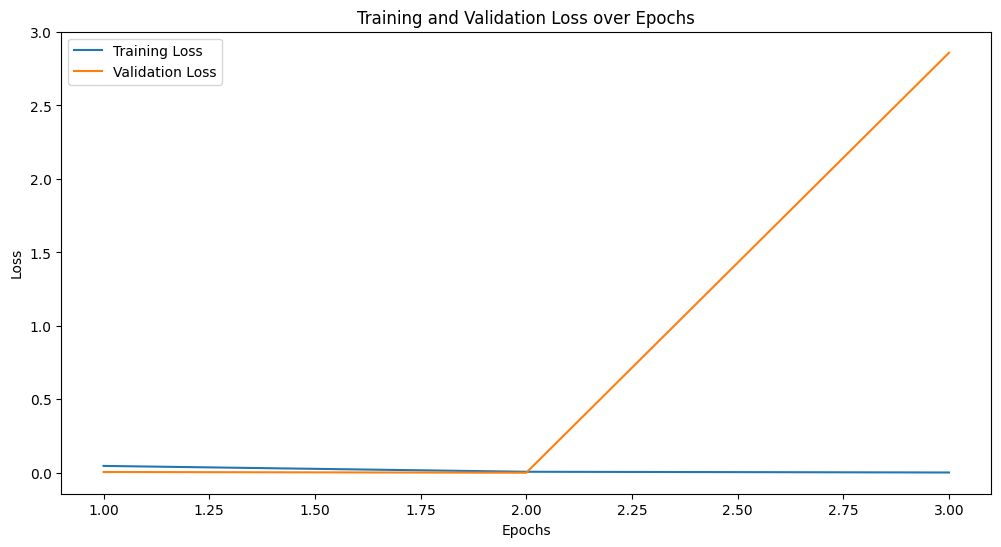

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
import os

data_dir = '/content/dataset'

categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []

for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(category_dir, filename)
            all_filepaths.append(filepath)
            all_labels.append(i)


train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


<ipython-input-22-abf9dfa56fd4>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device),strict=False)
<ipython-in

Metrics: {'Accuracy': 0.9997607369302548, 'Precision': 1.0, 'Recall (Sensitivity)': 0.999485728979172, 'Specificity': 1.0, 'F1 Score': 0.9997427983539094, 'AUC': 0.9999737687264544}


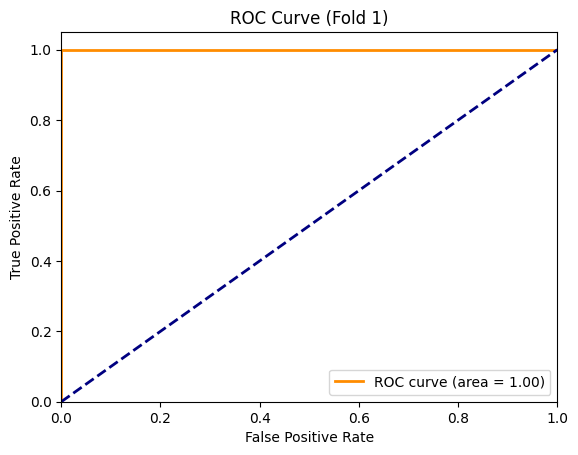

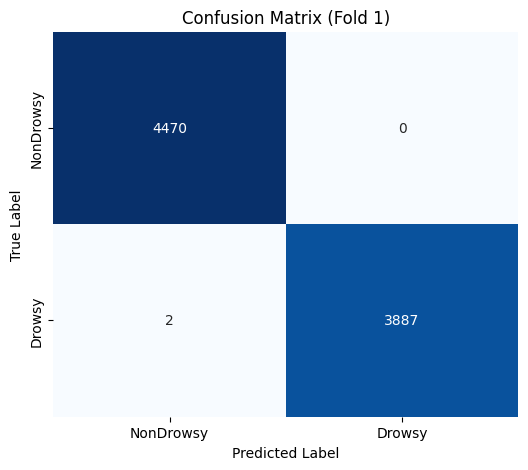

Train and validation losses not available.
Predictions: [0 0 0 1 1 1 1 0 0 1]
Probabilities: [[9.9998951e-01 1.0458756e-05]
 [9.9999869e-01 1.2986897e-06]
 [9.9986386e-01 1.3613314e-04]
 [1.4600917e-07 9.9999988e-01]
 [1.9078303e-07 9.9999976e-01]
 [9.1159658e-05 9.9990880e-01]
 [1.3329566e-07 9.9999988e-01]
 [9.9998164e-01 1.8312114e-05]
 [9.9999547e-01 4.5108304e-06]
 [5.1217345e-08 1.0000000e+00]]
Labels: [0 0 0 1 1 1 1 0 0 1]


In [ ]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms
from timm import create_model
import torch
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
def fix_state_dict_keys(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith("backbone."):
            new_key = key.replace("backbone.", "")  # Ön eki kaldır
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict



def load_model(model_path, num_classes, device):
    # LeViT modelini oluşturun
    model = create_model('levit_384', pretrained=False, num_classes=num_classes)

    # Modeli cihaz üzerinde yükleyin
    model = model.to(device)

    # Eğitilmiş ağırlıkları yükleyin
    model.load_state_dict(torch.load(model_path, map_location=device),strict=False)

    return model

def plot_loss_graph(train_losses, val_losses):

    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
def plot_confusion_matrix(labels, preds, fold=0):
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['NonDrowsy', 'Drowsy'], yticklabels=['NonDrowsy', 'Drowsy'])
    plt.title(f'Confusion Matrix (Fold {fold + 1})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
def plot_roc_curve(labels, probs, fold=0):
    fpr, tpr, thresholds = roc_curve(labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Fold {fold + 1})')
    plt.legend(loc='lower right')
    plt.show()
def calculate_metrics(labels, preds, probs):
    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average="binary")

    recall = recall_score(labels, preds, average="binary")

    f1 = f1_score(labels, preds, average="binary")

    auc = roc_auc_score(labels, probs[:, 1])

    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "AUC": auc,
    }

    return metrics

def inference(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

data_dir = '/content/dataset'

categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []

for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(category_dir, filename)
            all_filepaths.append(filepath)
            all_labels.append(i)

train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

test_dataset = CustomDataset(test_filepaths, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/content/levit_model_fold_4.pth'
model = load_model(model_path, num_classes=len(categories), device=device)

# Ağırlıkları yükle ve anahtarları düzelt
model_state_dict = torch.load(model_path, map_location=device)
fixed_state_dict = fix_state_dict_keys(model_state_dict)

# Düzeltilmiş ağırlıkları modele yükle
model.load_state_dict(fixed_state_dict)
all_preds, all_probs, all_labels = inference(model, test_loader, device)

metrics = calculate_metrics(all_labels, all_preds, all_probs)
print("Metrics:", metrics)

plot_roc_curve(all_labels, all_probs, fold=0)
plot_confusion_matrix(all_labels, all_preds, fold=0)

if 'train_losses' in locals() and 'val_losses' in locals():
    plot_loss_graph(train_losses, val_losses)
else:
    print("Train and validation losses not available.")

print("Predictions:", all_preds[:10])
print("Probabilities:", all_probs[:10])
print("Labels:", all_labels[:10])



In [ ]:
!pip install onnx_tf

<ipython-input-52-f7437ea2f062>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Frame Rate: 29.893904051424826, Total Frames: 309
Total Predictions: 309


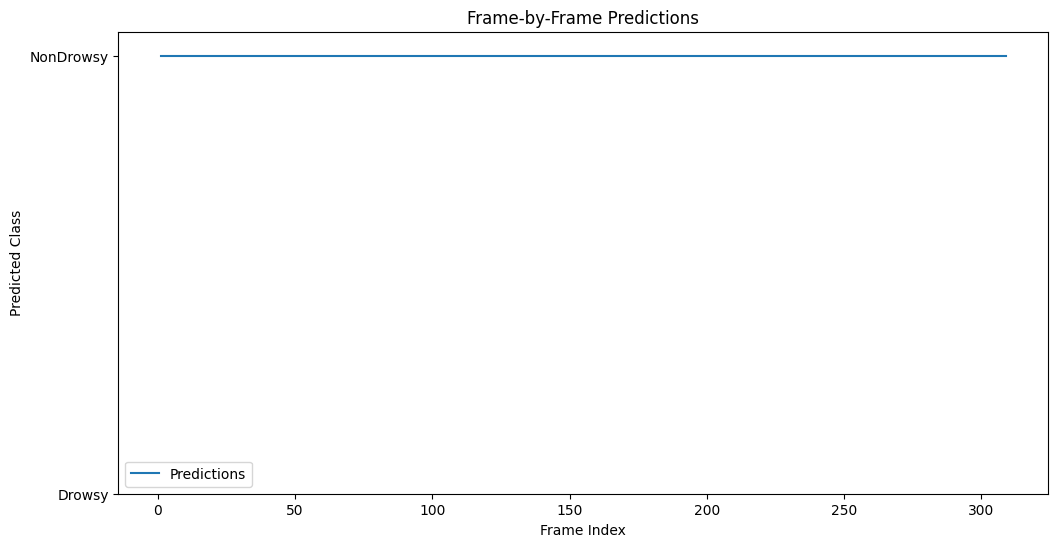

Video-based Accuracy: 1.0000


In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from timm import create_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

categories = ['Drowsy', 'NonDrowsy']
num_classes = len(categories)

class LeViTModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(LeViTModel, self).__init__()
        self.backbone = create_model('levit_384', pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

model_path = '/content/levit_model_fold_4.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeViTModel(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

video_path = "/content/makine/test.mp4"
cap = cv2.VideoCapture(video_path)

frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Frame Rate: {frame_rate}, Total Frames: {frame_count}")

predictions = []
frame_indices = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)

    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()
        predictions.append(pred_label)

    frame_indices.append(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))

cap.release()

print(f"Total Predictions: {len(predictions)}")
frame_classes = [categories[p] for p in predictions]

plt.figure(figsize=(12, 6))
plt.plot(frame_indices, predictions, label="Predictions")
plt.yticks(range(len(categories)), categories)
plt.xlabel("Frame Index")
plt.ylabel("Predicted Class")
plt.title("Frame-by-Frame Predictions")
plt.legend()
plt.show()

ground_truth = 1
accuracy = np.mean(np.array(predictions) == ground_truth)
print(f"Video-based Accuracy: {accuracy:.4f}")


In [ ]:
!curl --output "/content/makine/haarcascade_frontalface_alt.xml" https://cdn.hackaday.io/files/275521178784768/haarcascade_frontalface_alt.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  898k  100  898k    0     0  11.2M      0 --:--:-- --:--:-- --:--:-- 11.3M


In [ ]:
def inference(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)


In [ ]:
!pip install timm
!pip install torch torchvision
!pip install numpy pandas matplotlib seaborn scikit-learn